# Task 1 Notebook File - 20MIP10033 - Chandan Thota

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error

In [2]:
# Loading the dataset
train = pd.read_csv("orgData/train.csv")

In [3]:
# Checking the size of the dataset
train.shape

(101490, 8)

In [4]:
# Checking the data types
train.dtypes

ID             object
date           object
Item Id        object
Item Name      object
ad_spend      float64
anarix_id      object
units         float64
unit_price    float64
dtype: object

In [5]:
# Coverting the datatype of "date" column to datatime
train['date'] = pd.to_datetime(train['date'])
train.set_index('date', inplace=True)
print(train.dtypes)

ID             object
Item Id        object
Item Name      object
ad_spend      float64
anarix_id      object
units         float64
unit_price    float64
dtype: object


In [6]:
# Checking the data
train.head()

,ID,Item Id,Item Name,ad_spend,anarix_id,units,unit_price
date,,,,,,,
2022-04-12,2022-04-12_B09KDTS4DC,B09KDTS4DC,"NapQueen Elizabeth 8"" Gel Memory Foam Mattress...",NaN,NAPQUEEN,0.0,0.0
2022-04-12,2022-04-12_B09MR2MLZH,B09MR2MLZH,NapQueen 12 Inch Bamboo Charcoal Queen Size Me...,NaN,NAPQUEEN,0.0,0.0
2022-04-12,2022-04-12_B09KSYL73R,B09KSYL73R,"NapQueen Elsa 8"" Innerspring Mattress, Twin XL",NaN,NAPQUEEN,0.0,0.0
2022-04-12,2022-04-12_B09KT5HMNY,B09KT5HMNY,"NapQueen Elsa 6"" Innerspring Mattress, Twin",NaN,NAPQUEEN,0.0,0.0
2022-04-12,2022-04-12_B09KTF8ZDQ,B09KTF8ZDQ,"NapQueen Elsa 6"" Innerspring Mattress, Twin XL",NaN,NAPQUEEN,0.0,0.0


### Data Preprocessing Stage 1

In [7]:
# Checking if there are any null values in the entire DataFrame
exists = train.isnull().values.any()
print(exists)

True


In [8]:
# Creating a function with calculates the null percentage of a column/feature
def null_percent(df):
    null_df = df.isnull().sum().reset_index()
    null_df.columns = ['Column', 'Null Count']
    null_df['Null Percentage'] = round((null_df['Null Count'] / len(train)) * 100, 3)

    return null_df

In [9]:
# Checking the count and percent of nulls present in features
nulls = null_percent(train)
nulls

,Column,Null Count,Null Percentage
0,ID,0,0.000
1,Item Id,2,0.002
2,Item Name,1832,1.805
3,ad_spend,24187,23.832
4,anarix_id,0,0.000
5,units,17898,17.635
6,unit_price,0,0.000


In [10]:
# checking if nulls exist in both item id and name
count_both_null = train[(train['Item Id'].isnull()) & (train['Item Name'].isnull())]
count_both_null.head()

,ID,Item Id,Item Name,ad_spend,anarix_id,units,unit_price
date,,,,,,,
2024-04-07,2024-04-07_nan,NaN,NaN,0.0,NAPQUEEN,NaN,0.0
2024-04-18,2024-04-18_nan,NaN,NaN,0.0,NAPQUEEN,NaN,0.0


In [11]:
# Removing the null rows from the dataset [based on above result]
train = train.dropna(subset=['Item Id', 'Item Name'], how='all')
train.shape

(101488, 7)

In [12]:
# Filling the null values of feature "Item Name" using forward fill 
# Save the original indices
train['Original Index'] = train.index

# Sort by 'Item Id'
train_sorted = train.sort_values(by='Item Id')

# Forward fill 'Item Name'
train_sorted['Item Name'] = train_sorted['Item Name'].ffill()

# Restore the original order using the saved index
train = train_sorted.sort_values(by='Original Index').drop(columns='Original Index')

In [13]:
# Checking the count and percent of nulls present in features
nulls = null_percent(train)
nulls

,Column,Null Count,Null Percentage
0,ID,0,0.000
1,Item Id,0,0.000
2,Item Name,3,0.003
3,ad_spend,24187,23.832
4,anarix_id,0,0.000
5,units,17896,17.634
6,unit_price,0,0.000


In [14]:
# Checking why are the nulls still present in Item Name
nulls = train[(train['Item Name'].isnull())]
nulls.head()

,ID,Item Id,Item Name,ad_spend,anarix_id,units,unit_price
date,,,,,,,
2023-09-25,2023-09-25_ASIN_BLANK,ASIN_BLANK,NaN,0.0,NAPQUEEN,NaN,0.0
2023-10-10,2023-10-10_ASIN_BLANK,ASIN_BLANK,NaN,0.0,NAPQUEEN,NaN,0.0
2023-11-02,2023-11-02_ASIN_BLANK,ASIN_BLANK,NaN,0.0,NAPQUEEN,NaN,0.0


In [15]:
# Checking the count of ASIN_Blank [based on above result]
count_asin_blank = (train['Item Id'].str.contains('ASIN_BLANK')).sum()
print(count_asin_blank)

3


In [16]:
# Dropping this rows since they contain mostly null values [based on above result]
train = train[~(train['Item Id'].str.contains('ASIN_BLANK'))]
print(train.shape)

(101485, 7)


In [17]:
# Checking the count and percent of nulls present in features
nulls = null_percent(train)
nulls

,Column,Null Count,Null Percentage
0,ID,0,0.000
1,Item Id,0,0.000
2,Item Name,0,0.000
3,ad_spend,24187,23.833
4,anarix_id,0,0.000
5,units,17893,17.631
6,unit_price,0,0.000


In [18]:
# Imputing missing values for 'ad_spend' using forward and backward fill
train['ad_spend'] = train['ad_spend'].ffill().bfill()

In [19]:
# Checking the count and percent of nulls present in features
nulls = null_percent(train)
nulls

,Column,Null Count,Null Percentage
0,ID,0,0.000
1,Item Id,0,0.000
2,Item Name,0,0.000
3,ad_spend,0,0.000
4,anarix_id,0,0.000
5,units,17893,17.631
6,unit_price,0,0.000


In [20]:
### Splitting the datasets [Known and Unknown] [based on nulls present in the column "units" -> target variable]
known_df = train[train['units'].notnull()]
unknown_df = train[train['units'].isnull()]
print(known_df.shape)
print(unknown_df.shape)

(83592, 7)
(17893, 7)


#### EDA

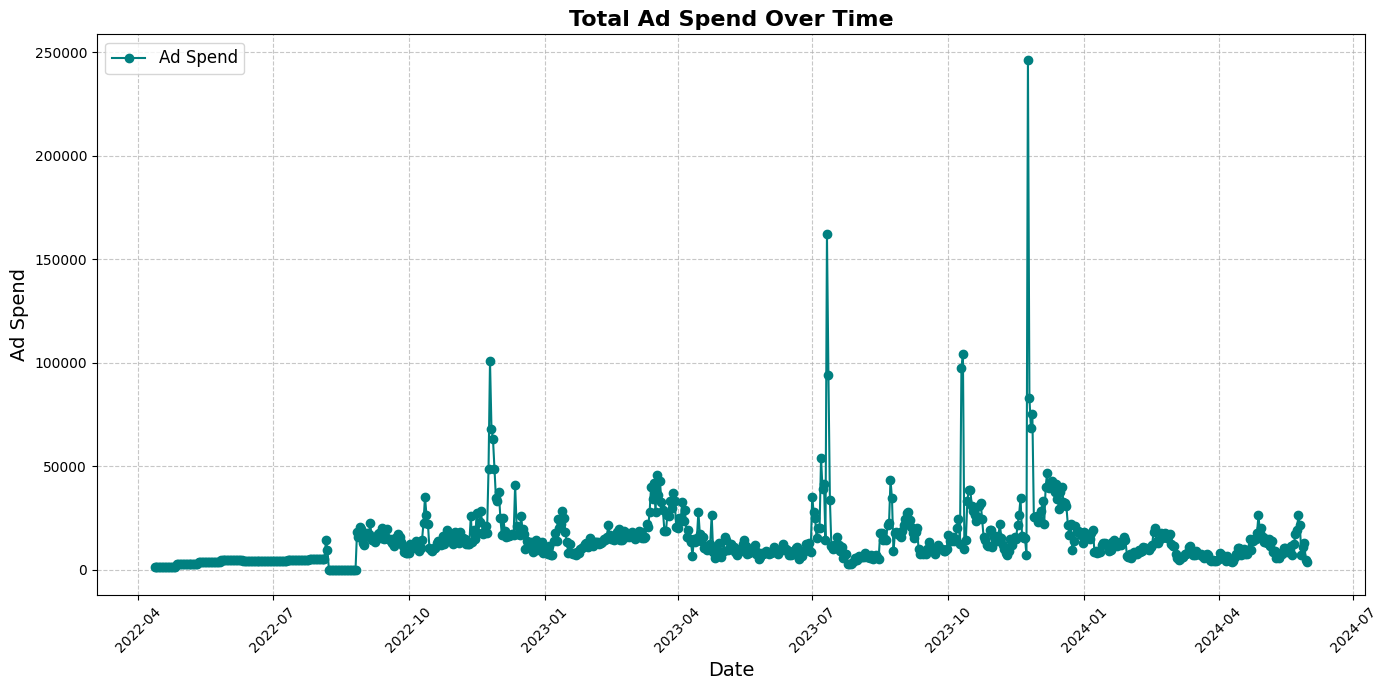

In [21]:
# Graph 1: - Plotting total and spend over time
plt.figure(figsize=(14, 7))
plt.plot(known_df.groupby('date')['ad_spend'].sum(), color='teal', linestyle='-', marker='o', label='Ad Spend')
plt.title('Total Ad Spend Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Ad Spend', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

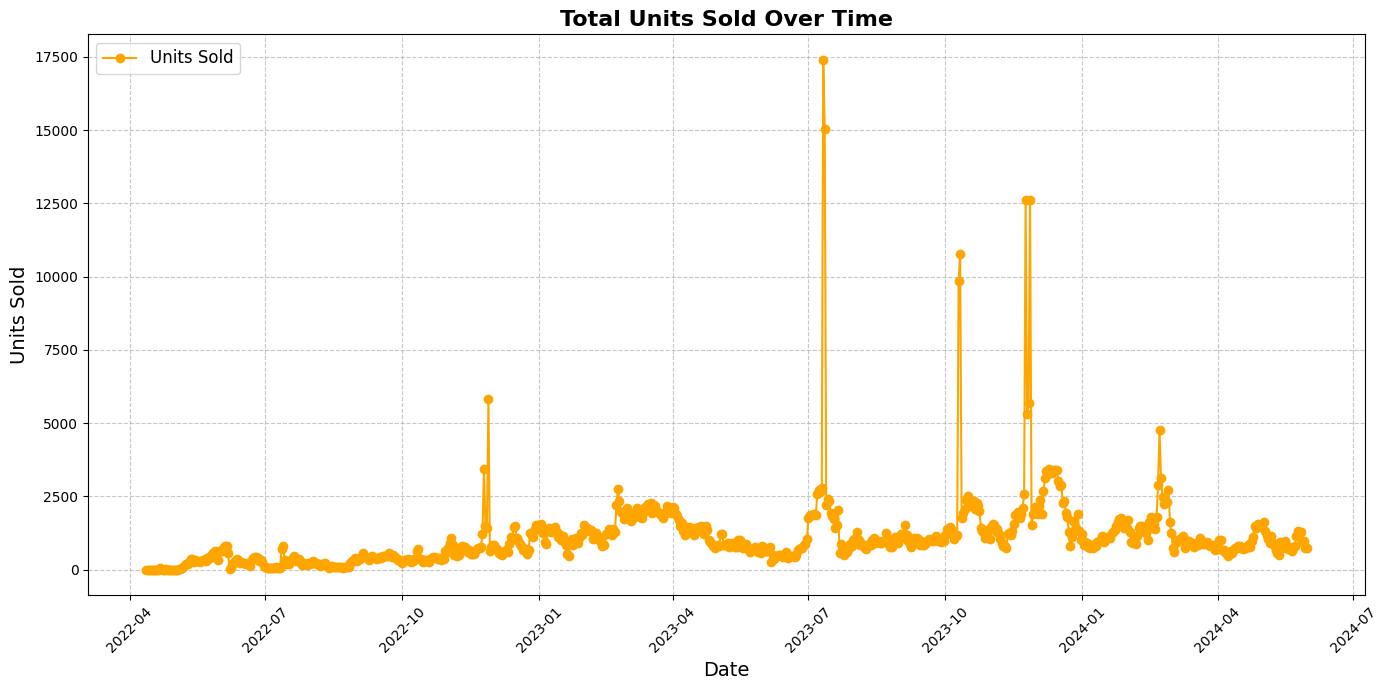

In [22]:
# Graph 2: - Plot total units sold over time
plt.figure(figsize=(14, 7))
plt.plot(known_df.groupby('date')['units'].sum(), color='orange', linestyle='-', marker='o', label='Units Sold')
plt.title('Total Units Sold Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Units Sold', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

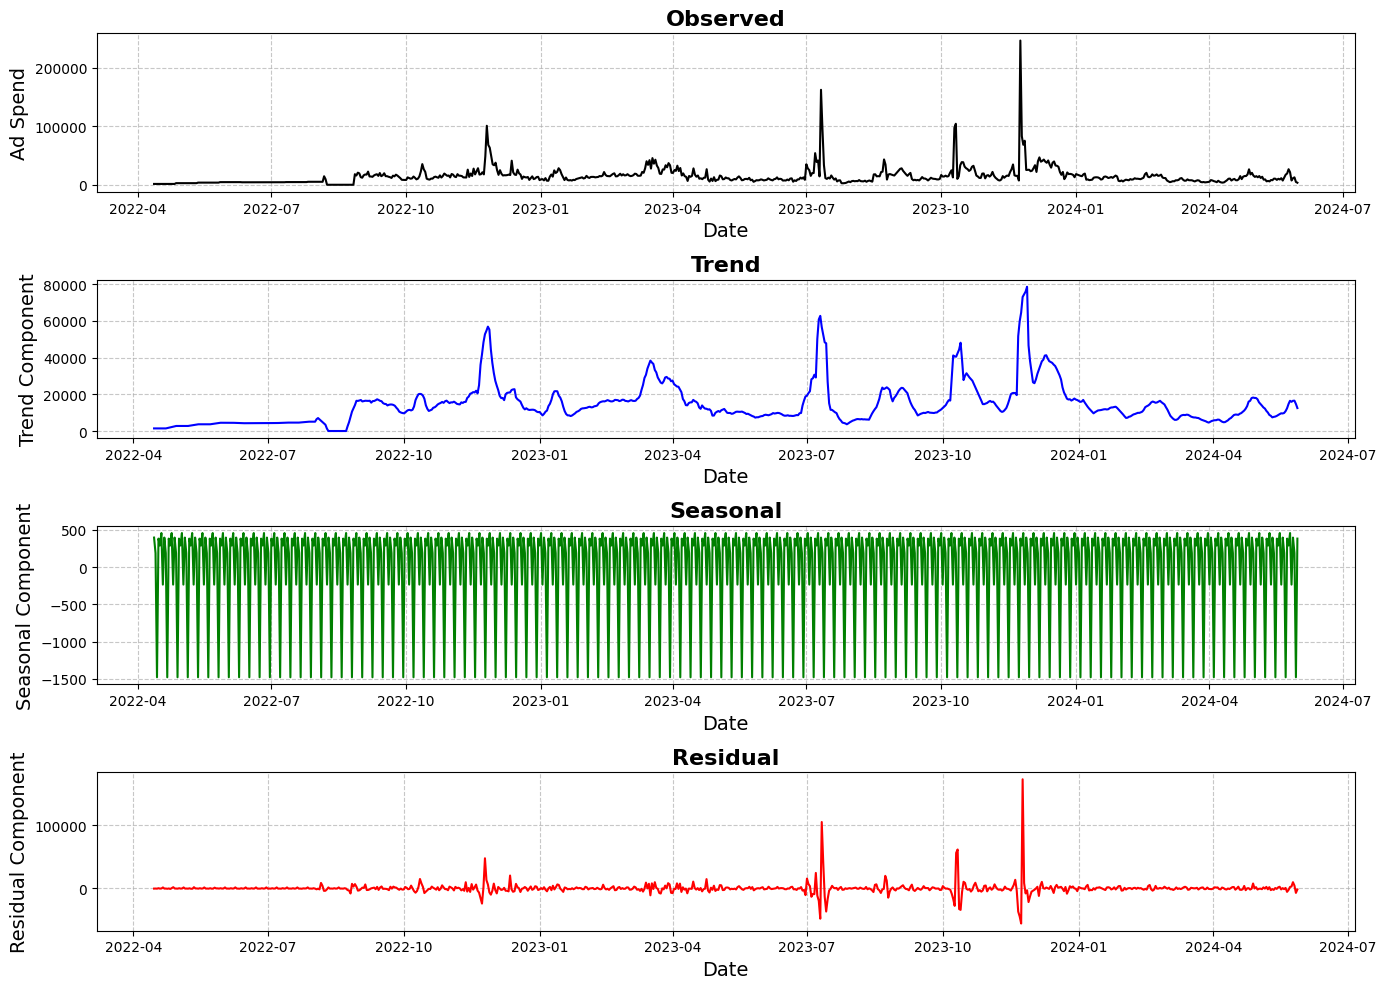

In [23]:
# Graph 3: - Plotting the observed, trend, seasonal and residual of column "ad_spend" over "date"
result = seasonal_decompose(known_df['ad_spend'].resample('D').sum(), model='additive')
plt.figure(figsize=(14, 10))

# Plotting observed
plt.subplot(4, 1, 1)
plt.plot(result.observed, color='black')
plt.title('Observed', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Ad Spend', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Plotting trend
plt.subplot(4, 1, 2)
plt.plot(result.trend, color='blue')
plt.title('Trend', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Trend Component', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Plotting seasonal
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, color='green')
plt.title('Seasonal', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Seasonal Component', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Plotting residual
plt.subplot(4, 1, 4)
plt.plot(result.resid, color='red')
plt.title('Residual', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residual Component', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

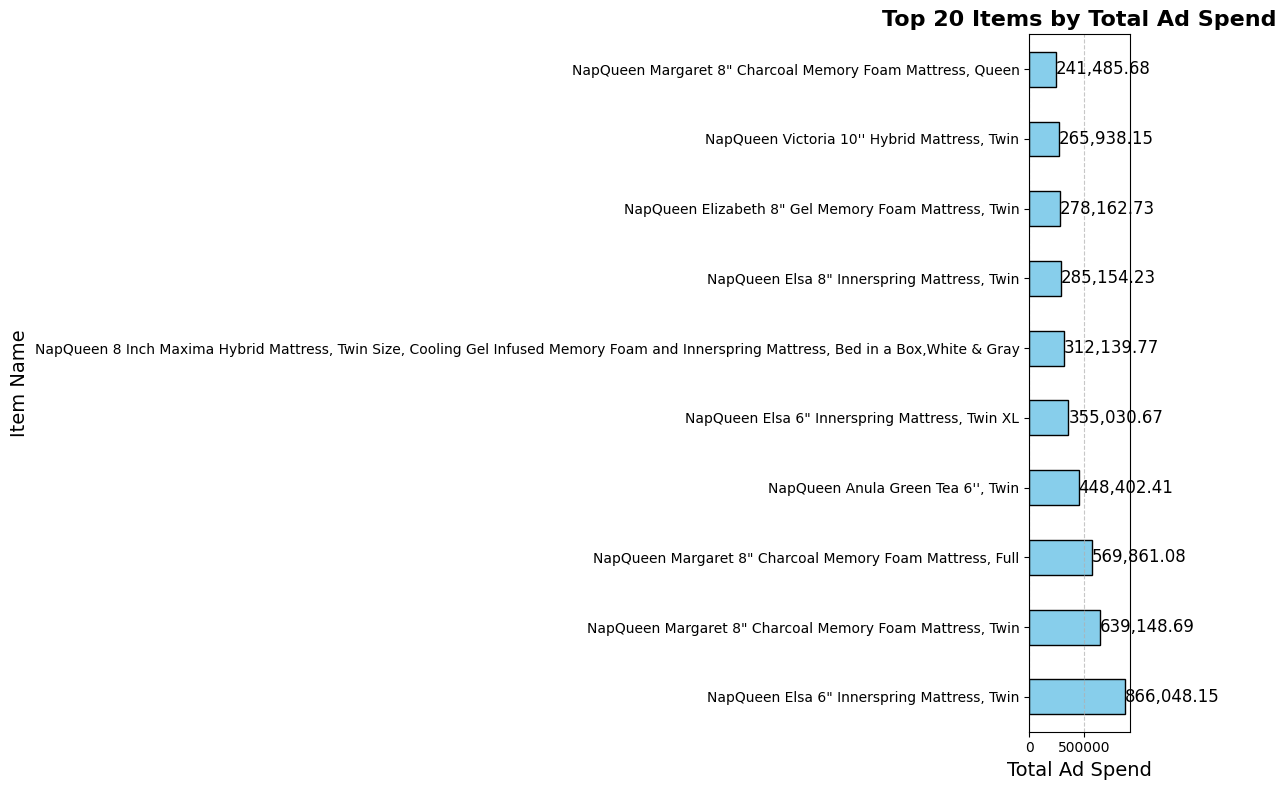

In [24]:
# Graph 4: - top 10 items by total :ad_spend"
item_counts = known_df['Item Name'].value_counts()
top_items = known_df.groupby('Item Name')['ad_spend'].sum().nlargest(10)
plt.figure(figsize=(12, 8))
top_items.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Top 20 Items by Total Ad Spend', fontsize=16, fontweight='bold')
plt.xlabel('Total Ad Spend', fontsize=14)
plt.ylabel('Item Name', fontsize=14)
for index, value in enumerate(top_items):
    plt.text(value, index, f'{value:,.2f}', va='center', fontsize=12, color='black')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

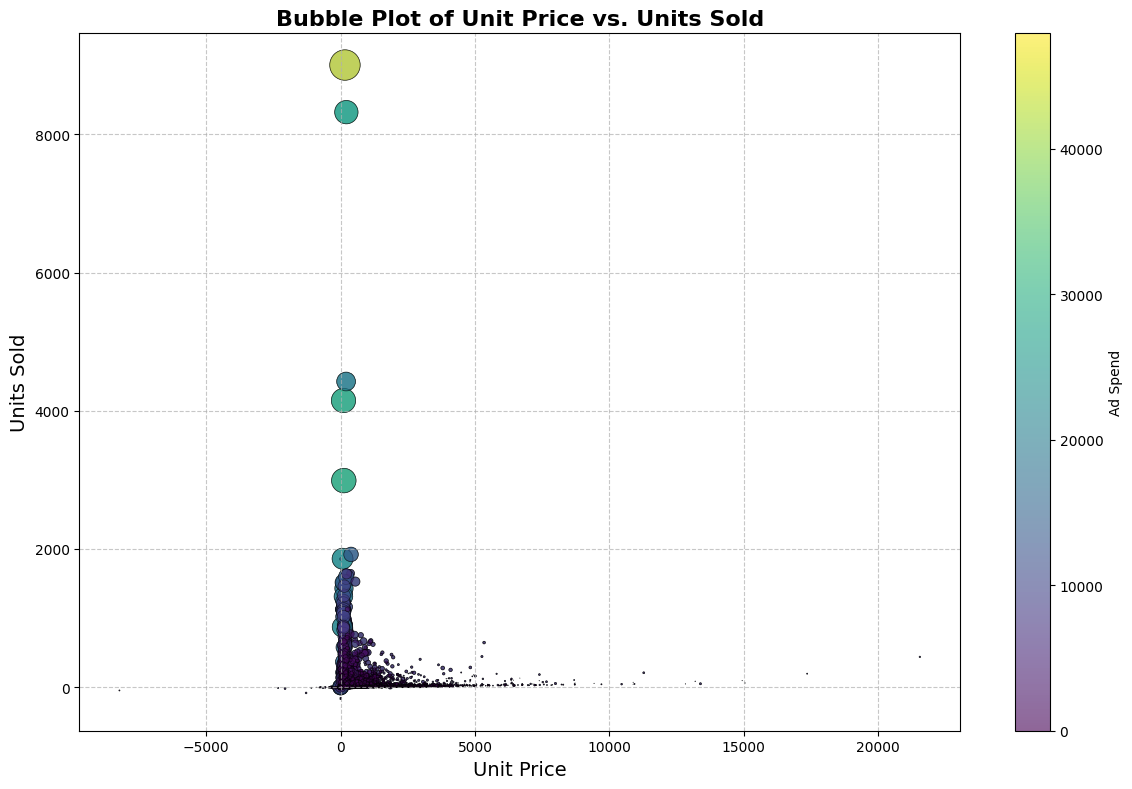

In [25]:
# Graph 5: - bubble plot of unit price vs units sold
plt.figure(figsize=(12, 8))
plt.scatter(
    known_df['unit_price'], 
    known_df['units'], 
    s=known_df['ad_spend'] / 100,
    c='teal',
    alpha=0.6,
    edgecolor='k',
    linewidth=0.5
)
plt.title('Bubble Plot of Unit Price vs. Units Sold', fontsize=16, fontweight='bold')
plt.xlabel('Unit Price', fontsize=14)
plt.ylabel('Units Sold', fontsize=14)
sc = plt.scatter(
    known_df['unit_price'], 
    known_df['units'], 
    s=known_df['ad_spend'] / 100, 
    c=known_df['ad_spend'], 
    cmap='viridis', 
    alpha=0.6, 
    edgecolor='k', 
    linewidth=0.5
)
plt.colorbar(sc, label='Ad Spend')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Feature Engineering

In [26]:
# Checking the correlation of numerical features
print(known_df[['ad_spend', 'units', 'unit_price']].corr())

            ad_spend     units  unit_price
ad_spend    1.000000  0.693707    0.026250
units       0.693707  1.000000    0.088579
unit_price  0.026250  0.088579    1.000000


In [27]:
# copying the dataset to remove unwanted errors
known_df = known_df.copy()

In [28]:
# Extract meaningful features from 'date' column
known_df.loc[:, 'year'] = known_df.index.year
known_df.loc[:, 'month'] = known_df.index.month
known_df.loc[:, 'day'] = known_df.index.day
known_df.loc[:, 'day_of_week'] = known_df.index.day_name()
known_df.loc[:, 'is_weekend'] = known_df.index.dayofweek >= 5
known_df.loc[:, 'quarter'] = known_df.index.quarter

In [29]:
# Checking the dataset
known_df.head()

,ID,Item Id,Item Name,ad_spend,anarix_id,units,unit_price,year,month,day,day_of_week,is_weekend,quarter
date,,,,,,,,,,,,,
2022-04-12,2022-04-12_B09MR5Q6HJ,B09MR5Q6HJ,"NapQueen Margaret 10"" Charcoal Memory Foam Mat...",83.21,NAPQUEEN,0.0,0.0,2022,4,12,Tuesday,False,2
2022-04-12,2022-04-12_B09KTF8ZDQ,B09KTF8ZDQ,"NapQueen Elsa 6"" Innerspring Mattress, Twin XL",83.21,NAPQUEEN,0.0,0.0,2022,4,12,Tuesday,False,2
2022-04-12,2022-04-12_B09MR4B13C,B09MR4B13C,"NapQueen Margaret 8"" Charcoal Memory Foam Matt...",83.21,NAPQUEEN,0.0,0.0,2022,4,12,Tuesday,False,2
2022-04-12,2022-04-12_B09MR5WS3Y,B09MR5WS3Y,"NapQueen Margaret 8"" Charcoal Memory Foam Matt...",83.21,NAPQUEEN,0.0,0.0,2022,4,12,Tuesday,False,2
2022-04-12,2022-04-12_B09KT5HMNY,B09KT5HMNY,"NapQueen Elsa 6"" Innerspring Mattress, Twin",83.21,NAPQUEEN,0.0,0.0,2022,4,12,Tuesday,False,2


In [30]:
# Splitting the known_df into 2 datasets with ratio (8:2)
X = known_df.drop(columns=['ID', 'units', 'Item Id', 'anarix_id'])
y = known_df["units"]

label_encoder = LabelEncoder()
X['Item Name'] = label_encoder.fit_transform(X['Item Name'])
X['day_of_week'] = label_encoder.fit_transform(X['day_of_week'])
X['is_weekend'] = label_encoder.fit_transform(X['is_weekend'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Loading and training the model Random Forest (ensemble) (Regressor)
model = RandomForestRegressor(
    n_estimators=100,
    criterion='squared_error',
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=42,
    verbose=2,
    warm_start=False
)

model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.4s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100building tree 53 of 100

building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished


RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=5, n_jobs=-1, oob_score=True,
                      random_state=42, verbose=2)

In [32]:
# Creating a SHAP explainer using the trained random forest model
explainer = shap.TreeExplainer(model, X_train)

# Computing the SHAP values on the validation data
shap_values = explainer(X_test, check_additivity=False)

100%|===================| 16710/16719 [03:22<00:00]        

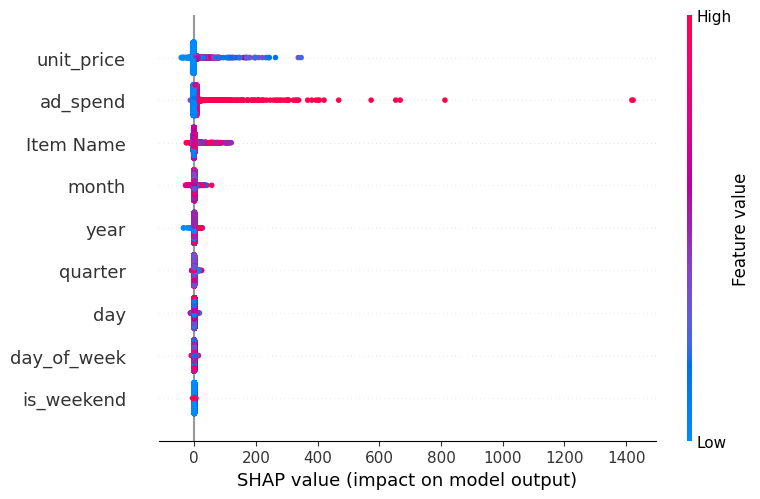

In [33]:
# Graph 6: - Visualizing the calculated SHAP values
shap.summary_plot(shap_values, X_test, plot_type='dot')

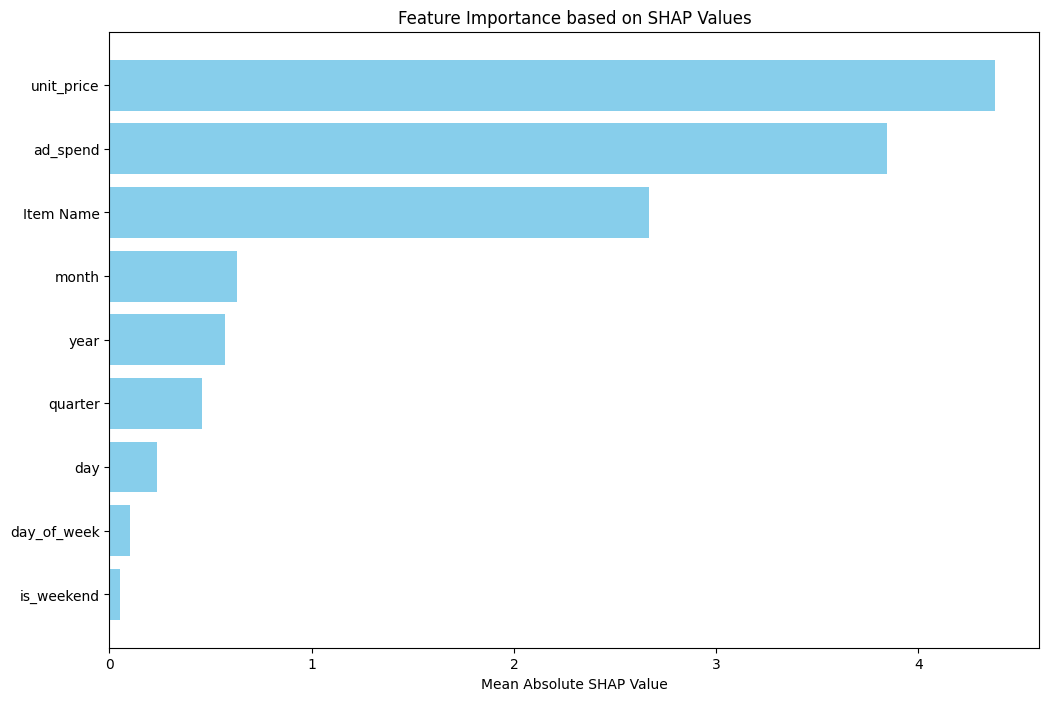

In [34]:
# Graph 7: - Feature importance based on SHAP values 
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(shap_importance['feature'], shap_importance['importance'], color='skyblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance based on SHAP Values')
plt.gca().invert_yaxis()
plt.show()

#### Data Preprocessing Stage 2

In [35]:
# Copying the dataset to remove unwanted errors
unknown_df = unknown_df.copy()

In [36]:
# Extract features from 'date' column
unknown_df.loc[:, 'year'] = unknown_df.index.year
unknown_df.loc[:, 'month'] = unknown_df.index.month
unknown_df.loc[:, 'day'] = unknown_df.index.day
unknown_df.loc[:, 'day_of_week'] = unknown_df.index.day_name()
unknown_df.loc[:, 'is_weekend'] = unknown_df.index.dayofweek >= 5
unknown_df.loc[:, 'quarter'] = unknown_df.index.quarter

In [37]:
# Checking the dataset
unknown_df.head()

,ID,Item Id,Item Name,ad_spend,anarix_id,units,unit_price,year,month,day,day_of_week,is_weekend,quarter
date,,,,,,,,,,,,,
2022-08-06,2022-08-06_B09KDPXYG3,B09KDPXYG3,"NapQueen Elizabeth 12"" Gel Memory Foam Mattres...",83.21,NAPQUEEN,NaN,0.0,2022,8,6,Saturday,True,3
2022-08-06,2022-08-06_B09X1H629F,B09X1H629F,"NapQueen Elizabeth 14"" Gel Memory Foam Mattres...",16.73,NAPQUEEN,NaN,0.0,2022,8,6,Saturday,True,3
2022-08-06,2022-08-06_B0B69C4GST,B0B69C4GST,"NapQueen Victoria 12'' Hybrid Mattress, King",0.00,NAPQUEEN,NaN,0.0,2022,8,6,Saturday,True,3
2022-08-06,2022-08-06_B0B69SF1BT,B0B69SF1BT,"NapQueen Victoria 12'' Hybrid Mattress, Twin",5.98,NAPQUEEN,NaN,0.0,2022,8,6,Saturday,True,3
2022-08-06,2022-08-06_B09MR36MLJ,B09MR36MLJ,"NapQueen Margaret 10"" Charcoal Memory Foam Mat...",23.87,NAPQUEEN,NaN,0.0,2022,8,6,Saturday,True,3


In [38]:
# processing the unknown_df for filling the nulls values in column "units"
test_data_nulls = unknown_df.drop(columns=['ID', 'units', 'Item Id', 'anarix_id'])

test_data_nulls['Item Name'] = label_encoder.fit_transform(test_data_nulls['Item Name'])
test_data_nulls['day_of_week'] = label_encoder.fit_transform(test_data_nulls['day_of_week'])
test_data_nulls['is_weekend'] = label_encoder.fit_transform(test_data_nulls['is_weekend'])

In [39]:
# Predicting the null values in unknown_df
predicted_units = model.predict(test_data_nulls)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [40]:
# Checking the length of the predicted nulls
assert len(predicted_units) == len(unknown_df)

# Creating a Series for easy updating
predicted_units_series = pd.Series(predicted_units, index=unknown_df.index)

# Updating the training dataset
train.loc[train['units'].isnull(), 'units'] = predicted_units_series

In [41]:
# Checking the count and percent of nulls present in features
nulls = null_percent(train)
nulls

,Column,Null Count,Null Percentage
0,ID,0,0.0
1,Item Id,0,0.0
2,Item Name,0,0.0
3,ad_spend,0,0.0
4,anarix_id,0,0.0
5,units,0,0.0
6,unit_price,0,0.0


In [42]:
# Checking the dataset
train.head()

,ID,Item Id,Item Name,ad_spend,anarix_id,units,unit_price
date,,,,,,,
2022-04-12,2022-04-12_B09MR5Q6HJ,B09MR5Q6HJ,"NapQueen Margaret 10"" Charcoal Memory Foam Mat...",83.21,NAPQUEEN,0.0,0.0
2022-04-12,2022-04-12_B09KTF8ZDQ,B09KTF8ZDQ,"NapQueen Elsa 6"" Innerspring Mattress, Twin XL",83.21,NAPQUEEN,0.0,0.0
2022-04-12,2022-04-12_B09MR4B13C,B09MR4B13C,"NapQueen Margaret 8"" Charcoal Memory Foam Matt...",83.21,NAPQUEEN,0.0,0.0
2022-04-12,2022-04-12_B09MR5WS3Y,B09MR5WS3Y,"NapQueen Margaret 8"" Charcoal Memory Foam Matt...",83.21,NAPQUEEN,0.0,0.0
2022-04-12,2022-04-12_B09KT5HMNY,B09KT5HMNY,"NapQueen Elsa 6"" Innerspring Mattress, Twin",83.21,NAPQUEEN,0.0,0.0


In [43]:
# Loading the test data
test = pd.read_csv("orgData/test.csv")

In [44]:
# Coverting the datatype of "date" column to datatime
test['date'] = pd.to_datetime(test['date'])
test.set_index('date', inplace=True)
print(test.dtypes)

ID             object
Item Id        object
Item Name      object
ad_spend      float64
anarix_id      object
unit_price    float64
dtype: object


In [45]:
# Checking the dataset
test.head()

,ID,Item Id,Item Name,ad_spend,anarix_id,unit_price
date,,,,,,
2024-07-01,2024-07-01_B09KDR64LT,B09KDR64LT,"NapQueen Elizabeth 10"" Gel Memory Foam Mattres...",NaN,NAPQUEEN,0.0
2024-07-01,2024-07-01_B09KDTS4DC,B09KDTS4DC,"NapQueen Elizabeth 8"" Gel Memory Foam Mattress...",NaN,NAPQUEEN,0.0
2024-07-01,2024-07-01_B09KDTHJ6V,B09KDTHJ6V,"NapQueen Elizabeth 12"" Gel Memory Foam Mattres...",NaN,NAPQUEEN,0.0
2024-07-01,2024-07-01_B09KDQ2BWY,B09KDQ2BWY,"NapQueen Elizabeth 12"" Gel Memory Foam Mattres...",NaN,NAPQUEEN,0.0
2024-07-01,2024-07-01_B09KDYY3SB,B09KDYY3SB,"NapQueen Elizabeth 10"" Gel Memory Foam Mattres...",101.72,NAPQUEEN,1094.5


In [46]:
# Extract features from the "date" column [Both the train and test datasets]
train.loc[:, 'year'] = train.index.year
train.loc[:, 'month'] = train.index.month
train.loc[:, 'day'] = train.index.day
train.loc[:, 'day_of_week'] = train.index.day_name()
train.loc[:, 'is_weekend'] = train.index.dayofweek >= 5
train.loc[:, 'quarter'] = train.index.quarter

test.loc[:, 'year'] = test.index.year
test.loc[:, 'month'] = test.index.month
test.loc[:, 'day'] = test.index.day
test.loc[:, 'day_of_week'] = test.index.day_name()
test.loc[:, 'is_weekend'] = test.index.dayofweek >= 5
test.loc[:, 'quarter'] = test.index.quarter

In [47]:
# Checking the datasets
train.head()

,ID,Item Id,Item Name,ad_spend,anarix_id,units,unit_price,year,month,day,day_of_week,is_weekend,quarter
date,,,,,,,,,,,,,
2022-04-12,2022-04-12_B09MR5Q6HJ,B09MR5Q6HJ,"NapQueen Margaret 10"" Charcoal Memory Foam Mat...",83.21,NAPQUEEN,0.0,0.0,2022,4,12,Tuesday,False,2
2022-04-12,2022-04-12_B09KTF8ZDQ,B09KTF8ZDQ,"NapQueen Elsa 6"" Innerspring Mattress, Twin XL",83.21,NAPQUEEN,0.0,0.0,2022,4,12,Tuesday,False,2
2022-04-12,2022-04-12_B09MR4B13C,B09MR4B13C,"NapQueen Margaret 8"" Charcoal Memory Foam Matt...",83.21,NAPQUEEN,0.0,0.0,2022,4,12,Tuesday,False,2
2022-04-12,2022-04-12_B09MR5WS3Y,B09MR5WS3Y,"NapQueen Margaret 8"" Charcoal Memory Foam Matt...",83.21,NAPQUEEN,0.0,0.0,2022,4,12,Tuesday,False,2
2022-04-12,2022-04-12_B09KT5HMNY,B09KT5HMNY,"NapQueen Elsa 6"" Innerspring Mattress, Twin",83.21,NAPQUEEN,0.0,0.0,2022,4,12,Tuesday,False,2


In [48]:
# Checking the datasets
test.head()

,ID,Item Id,Item Name,ad_spend,anarix_id,unit_price,year,month,day,day_of_week,is_weekend,quarter
date,,,,,,,,,,,,
2024-07-01,2024-07-01_B09KDR64LT,B09KDR64LT,"NapQueen Elizabeth 10"" Gel Memory Foam Mattres...",NaN,NAPQUEEN,0.0,2024,7,1,Monday,False,3
2024-07-01,2024-07-01_B09KDTS4DC,B09KDTS4DC,"NapQueen Elizabeth 8"" Gel Memory Foam Mattress...",NaN,NAPQUEEN,0.0,2024,7,1,Monday,False,3
2024-07-01,2024-07-01_B09KDTHJ6V,B09KDTHJ6V,"NapQueen Elizabeth 12"" Gel Memory Foam Mattres...",NaN,NAPQUEEN,0.0,2024,7,1,Monday,False,3
2024-07-01,2024-07-01_B09KDQ2BWY,B09KDQ2BWY,"NapQueen Elizabeth 12"" Gel Memory Foam Mattres...",NaN,NAPQUEEN,0.0,2024,7,1,Monday,False,3
2024-07-01,2024-07-01_B09KDYY3SB,B09KDYY3SB,"NapQueen Elizabeth 10"" Gel Memory Foam Mattres...",101.72,NAPQUEEN,1094.5,2024,7,1,Monday,False,3


In [49]:
# Drop the unnecessary columns for the datasets
train_data = train.drop(columns=['ID', 'Item Id', 'anarix_id', 'units'], axis=1)
test_data = test.drop(columns=['ID', 'Item Id', 'anarix_id'], axis=1)

In [50]:
# Identify categorical and numerical features from the datasets
categorical_features = ['Item Name', 'day_of_week', 'day', 'is_weekend']
numerical_features = ['ad_spend', 'unit_price']

In [51]:
# Initializing the scaler for scaling the numeric features
scaler = StandardScaler()

In [52]:
# Fit and transform on train dataset
train_data[numerical_features] = scaler.fit_transform(train_data[numerical_features])

# Transform test dataset
test_data[numerical_features] = scaler.transform(test_data[numerical_features])

In [53]:
# Applying the one hot encoding to the train and test datasets
for column in categorical_features:
    train_data[column] = label_encoder.fit_transform(train_data[column])
    test_data[column] = label_encoder.fit_transform(test_data[column])

In [54]:
# Checking the dataset
train_data.head()

,Item Name,ad_spend,unit_price,year,month,day,day_of_week,is_weekend,quarter
date,,,,,,,,,
2022-04-12,162,-0.055726,-0.250771,2022,4,11,5,0,2
2022-04-12,154,-0.055726,-0.250771,2022,4,11,5,0,2
2022-04-12,180,-0.055726,-0.250771,2022,4,11,5,0,2
2022-04-12,178,-0.055726,-0.250771,2022,4,11,5,0,2
2022-04-12,153,-0.055726,-0.250771,2022,4,11,5,0,2


In [55]:
# Checking the dataset
test_data.head()

,Item Name,ad_spend,unit_price,year,month,day,day_of_week,is_weekend,quarter
date,,,,,,,,,
2024-07-01,79,NaN,-0.250771,2024,7,0,1,0,3
2024-07-01,92,NaN,-0.250771,2024,7,0,1,0,3
2024-07-01,83,NaN,-0.250771,2024,7,0,1,0,3
2024-07-01,81,NaN,-0.250771,2024,7,0,1,0,3
2024-07-01,78,-0.018401,2.320214,2024,7,0,1,0,3


In [56]:
# Saving the preprocessed datasets to variables for further processing
train = pd.concat([train_data, train['units']], axis=1)
test = pd.concat([test_data], axis=1)

In [57]:
# Checking the dataset
train.head()

,Item Name,ad_spend,unit_price,year,month,day,day_of_week,is_weekend,quarter,units
date,,,,,,,,,,
2022-04-12,162,-0.055726,-0.250771,2022,4,11,5,0,2,0.0
2022-04-12,154,-0.055726,-0.250771,2022,4,11,5,0,2,0.0
2022-04-12,180,-0.055726,-0.250771,2022,4,11,5,0,2,0.0
2022-04-12,178,-0.055726,-0.250771,2022,4,11,5,0,2,0.0
2022-04-12,153,-0.055726,-0.250771,2022,4,11,5,0,2,0.0


In [58]:
# Checking the dataset
test.head()

,Item Name,ad_spend,unit_price,year,month,day,day_of_week,is_weekend,quarter
date,,,,,,,,,
2024-07-01,79,NaN,-0.250771,2024,7,0,1,0,3
2024-07-01,92,NaN,-0.250771,2024,7,0,1,0,3
2024-07-01,83,NaN,-0.250771,2024,7,0,1,0,3
2024-07-01,81,NaN,-0.250771,2024,7,0,1,0,3
2024-07-01,78,-0.018401,2.320214,2024,7,0,1,0,3


In [59]:
# Creating a directory to save the processed train and test dataset
output_dir = 'proData'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [60]:
# Saving the processed datasets to the system
train.to_csv(os.path.join(output_dir, 'train_processed.csv'), index=True)
test.to_csv(os.path.join(output_dir, 'test_processed.csv'), index=True)

### Memory Optimization

In [61]:
# Checking the initial size of the datasets
print(train.info(memory_usage='deep'))
print(test.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 101485 entries, 2022-04-12 to 2024-05-31
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Item Name    101485 non-null  int32  
 1   ad_spend     101485 non-null  float64
 2   unit_price   101485 non-null  float64
 3   year         101485 non-null  int32  
 4   month        101485 non-null  int32  
 5   day          101485 non-null  int64  
 6   day_of_week  101485 non-null  int32  
 7   is_weekend   101485 non-null  int64  
 8   quarter      101485 non-null  int32  
 9   units        101485 non-null  float64
dtypes: float64(3), int32(5), int64(2)
memory usage: 6.6 MB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2833 entries, 2024-07-01 to 2024-07-28
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Item Name    2833 non-null   int32  
 1   ad_spend     1382 non-null   float64


In [62]:
# Creating a function which helps in downcasting the data for better memory optimization
def optimize_memory(df):
    float_cols = df.select_dtypes(include=['float64']).columns
    for col in float_cols:
        df[col] = pd.to_numeric(df[col], downcast='float')
    
    int_cols = df.select_dtypes(include=['int64']).columns
    for col in int_cols:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    
    return df

In [63]:
# Applying the created function
train = optimize_memory(train)
test = optimize_memory(test)

In [64]:
# Checking the results [based on above operations]
print(train.info(memory_usage='deep'))
print(test.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 101485 entries, 2022-04-12 to 2024-05-31
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Item Name    101485 non-null  int32  
 1   ad_spend     101485 non-null  float32
 2   unit_price   101485 non-null  float32
 3   year         101485 non-null  int32  
 4   month        101485 non-null  int32  
 5   day          101485 non-null  int8   
 6   day_of_week  101485 non-null  int32  
 7   is_weekend   101485 non-null  int8   
 8   quarter      101485 non-null  int32  
 9   units        101485 non-null  float32
dtypes: float32(3), int32(5), int8(2)
memory usage: 4.1 MB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2833 entries, 2024-07-01 to 2024-07-28
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Item Name    2833 non-null   int32  
 1   ad_spend     1382 non-null   float32
 

### Model Training and Selection

In [65]:
# Creating a directory to save the trained models
output_dir = 'Models'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [66]:
# Selected Features [based on feature importance results from SHAP library]
Features = ['Item Name', 'ad_spend', 'unit_price', 'year', 'month']

In [67]:
test_data = test[Features]

In [68]:
# Splitting the train dataset into train and val datasets to verify which model is best before predicting on test data
X_train, X_val, y_train, y_val = train_test_split(train[Features], train['units'], test_size=0.2, random_state=42)

#### XGB Model

In [69]:
# Creating datasets that the XGB model supports for faster training
XGBtrain = xgb.DMatrix(X_train, label=y_train)
XGBval = xgb.DMatrix(X_val, label=y_val)

In [70]:
# Hyper parameters for the XGB model
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'booster': 'gbtree'
}

In [71]:
# Training the XGB model
model_xgb = xgb.train(params, XGBtrain, 100, [(XGBval, 'eval')], early_stopping_rounds=10)

[0]	eval-rmse:76.31437
[1]	eval-rmse:74.44389
[2]	eval-rmse:72.89602
[3]	eval-rmse:71.63792
[4]	eval-rmse:70.42870
[5]	eval-rmse:69.42615
[6]	eval-rmse:68.54495
[7]	eval-rmse:67.81645
[8]	eval-rmse:67.15848
[9]	eval-rmse:66.67339
[10]	eval-rmse:66.30491
[11]	eval-rmse:65.78539
[12]	eval-rmse:65.43641
[13]	eval-rmse:65.16329
[14]	eval-rmse:64.79755
[15]	eval-rmse:64.53260


C:\Users\chand\Py_Env\nap\lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
C:\Users\chand\Py_Env\nap\lib\site-packages\xgboost\core.py:158: UserWarning: [20:24:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[16]	eval-rmse:63.89511
[17]	eval-rmse:63.62669
[18]	eval-rmse:63.44537
[19]	eval-rmse:63.19340
[20]	eval-rmse:63.02082
[21]	eval-rmse:62.84669
[22]	eval-rmse:62.22917
[23]	eval-rmse:62.08995
[24]	eval-rmse:61.90511
[25]	eval-rmse:61.83697
[26]	eval-rmse:61.76782
[27]	eval-rmse:61.62800
[28]	eval-rmse:61.07284
[29]	eval-rmse:60.86791
[30]	eval-rmse:60.49026
[31]	eval-rmse:60.02949
[32]	eval-rmse:59.83114
[33]	eval-rmse:59.81296
[34]	eval-rmse:59.80103
[35]	eval-rmse:59.67987
[36]	eval-rmse:59.30052
[37]	eval-rmse:59.14504
[38]	eval-rmse:59.12859
[39]	eval-rmse:59.14493
[40]	eval-rmse:58.99356
[41]	eval-rmse:58.78530
[42]	eval-rmse:58.82518
[43]	eval-rmse:58.57084
[44]	eval-rmse:58.53925
[45]	eval-rmse:58.52116
[46]	eval-rmse:58.52676
[47]	eval-rmse:58.24153
[48]	eval-rmse:58.20483
[49]	eval-rmse:57.92163
[50]	eval-rmse:57.86894
[51]	eval-rmse:57.83338
[52]	eval-rmse:57.79821
[53]	eval-rmse:57.79050
[54]	eval-rmse:57.77893
[55]	eval-rmse:57.75414
[56]	eval-rmse:57.73679
[57]	eval-rmse:5

In [72]:
# Make predictions using val data
y_pred_xgb = model_xgb.predict(XGBval)

In [73]:
# Evaluting the XGB model using mean squared error
mse_xgb = mean_squared_error(y_val, y_pred_xgb)

In [74]:
# Saving the model for later use
model_xgb.save_model(os.path.join(output_dir, 'xgboost_model.json'))

#### LGB Model

In [75]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [76]:
# Hyper parameters for the LGB model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

In [77]:
# Training the LGB model
model_lgb = lgb.train(params, lgb_train, 100, valid_sets=[lgb_train, lgb_val])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 726
[LightGBM] [Info] Number of data points in the train set: 81188, number of used features: 5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.660716


In [78]:
# Making predictions using the val data
y_pred_lgb = model_lgb.predict(X_val, num_iteration=model_lgb.best_iteration)

In [79]:
# Evaluate the LGB model using mean squared error
mse_lgb = mean_squared_error(y_val, y_pred_lgb)

In [80]:
# Saving the model for later use
model_lgb.save_model(os.path.join(output_dir, 'lightgbm_model.txt'))

#### LSTM

In [81]:
# Convert DataFrames to NumPy arrays
X_train_np = X_train.values
X_val_np = X_val.values

# Reshape for LSTM model input
n_features = X_train_np.shape[1]
X_train_reshaped = X_train_np.reshape((X_train_np.shape[0], 1, n_features))
X_val_reshaped = X_val_np.reshape((X_val_np.shape[0], 1, n_features))

In [82]:
# Building the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, input_shape=(1, n_features)))
model_lstm.add(Dense(units=1))

C:\Users\chand\Py_Env\nap\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [83]:
# Training the LSTM model
model_lstm.compile(optimizer='adam', loss='mse')
history = model_lstm.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_data=(X_val_reshaped, y_val), verbose=1) 

Epoch 1/50
2538/2538 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 4946.4199 - val_loss: 6164.2896
Epoch 2/50
2538/2538 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2987.3479 - val_loss: 6162.3457
Epoch 3/50
2538/2538 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2339.7659 - val_loss: 6162.4790
Epoch 4/50
2538/2538 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 7013.2588 - val_loss: 6162.7681
Epoch 5/50
2538/2538 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2500.1980 - val_loss: 6162.3330
Epoch 6/50
2538/2538 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2548.6807 - val_loss: 6162.4307
Epoch 7/50
2538/2538 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 3802.4062 - val_loss: 6162.4082
Epoch 8/50
2538/2538 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 3189.1250 - val_loss: 6162.2329
Epoch 9/50
2538/2538 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 3681.7754 - val_loss: 6162.3521
Epoch 10/50
2538/2538 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 2303.8928 - val_loss: 6162.2490
Epoch 11/50
2538/2538 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - lo

In [84]:
# Making predictions using the val data
y_pred_lstm = model_lstm.predict(X_val_reshaped)

635/635 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [85]:
# Evaluate the LSTM model using mean squared error
mse_lstm = mean_squared_error(y_val, y_pred_lstm)

In [86]:
# Saving the model for later use
model_lstm.save(os.path.join(output_dir, 'lstm_model.h5'))

#### Best Model

In [87]:
# Create a dictionary with MSE values
mse_data = {
    'Model': ['LGBM', 'XGBoost', 'LSTM'],
    'MSE': [mse_lgb, mse_xgb, mse_lstm]
}

# Create a DataFrame
mse_df = pd.DataFrame(mse_data)
print(mse_df)

     Model          MSE
0     LGBM  3476.089708
1  XGBoost  3227.409424
2     LSTM  6162.284668


### Testing new data

In [88]:
# Creating a directory to save the predictions
output_dir = 'Results'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [89]:
XGBtest = xgb.DMatrix(test_data[Features])

In [90]:
# Using the XGBoost model to predict the new test data (unseen data)
predictions = model_xgb.predict(XGBtest)

In [91]:
# Creating a csv file for saving the predictions
test = pd.read_csv("orgData/test.csv")
predictions_df = pd.DataFrame({
    'date': test['date'],
    'Item Id': test['Item Id'],
    'TARGET': predictions
})

# Saving the predictions to CSV file
predictions_df.to_csv(os.path.join(output_dir, 'predictions.csv'), index=False)
print("Predictions saved to 'predictions.csv'")

Predictions saved to 'predictions.csv'
